# Movielens 영화 SBR
-----
### 프로젝트 - Movielens 영화 SBR

**`Movielens 1M Dataset`**을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

## 순서
> **Step1.** 데이터의 전처리<br>
**Step2.** 미니 배치의 구성<br>
**Step3.** 모델 구성<br>
**Step4.** 모델 학습<br>
**Step5.** 모델 테스트<br>

## 용어정리
---

**✓ Session-Based Recommendation**이란?
>* 말 그대로 세션 데이터를 기반으로 **유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천**

>* **Session이란**이란?
>> * 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장
>> * 유저의 행동 데이터들은 유저측 브라우저를 통해 쿠키의 형태로 저장
>> * 쿠키는 세션과 상호작용하면서 정보를 주고 받음
>> * 이번 자료에서는 세션을 **브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터**와 같은 의미로 사용
>* 참고자료
>>* [쿠키, 세션, 캐시가 뭔가요?](https://www.youtube.com/watch?v=OpoVuwxGRDI)
>>* [쿠키, 세션이란?](https://chrisjune-13837.medium.com/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582)


**✓ 패키지(라이브러리)들을 import**

오늘 사용할 패키지를 불러옵니다.<br>터미널에서 **`pip install [패키지명]`**을 사용해 필요한 패키지를 설치해 주세요.<br>아래 명령어를 복사해서 설치해도 됩니다.

pathlib 라이브러리에 대한 내용은 [이쪽](https://brownbears.tistory.com/415#:~:text=pathlib%20%EC%84%A4%EB%AA%85,%EB%A1%9C%20%EB%8B%A4%EB%A3%A8%EC%9E%90%EB%8A%94%20%EA%B2%83%EC%9E%85%EB%8B%88%EB%8B%A4.&amp;text=pathlib%EC%9D%80%20%EC%8A%AC%EB%9E%98%EC%8B%9C(/)%EA%B0%80,%EC%A7%81%EA%B4%80%EC%A0%81%EC%9C%BC%EB%A1%9C%20%EC%9D%B4%ED%95%B4%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%8A%B5%EB%8B%88%EB%8B%A4.)을 참고해주세요.

>$ pip list | grep pathlib

>$ pip install pathlib

In [1]:
import os
import warnings
import datetime, time
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
warnings.filterwarnings('ignore')

Duplicate key in file PosixPath('/home/aiffel-dj49/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family: NanumGothic')


**✓ 데이터 설명을 보고 갈까요?**

In [2]:
# 데이터 설명(README)를 읽어 봅니다. 
f = open(os.getenv('HOME')+'/aiffel/yoochoose-data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

추천 시스템을 주로 다루는 학회 RecSys에서는 매년 추천을 주제로 대회를 개최합니다.
2015년도에는 YOOCHOOSE라는 추천 엔진 솔루션 회사에서 E-Commerce 데이터를 공개했습니다.
오늘은 이 데이터를 활용하겠습니다.

1) wget으로 데이터 다운로드
> $ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동
> $ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제
> $ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip

**✓ 데이터 로드 : 주요 통계치들은?**

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 **SessionID 대신 UserID 항목이 들어갔다는 점**입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- **Rating 정보가 포함**되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

### Step1. 데이터의 전처리
---
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

데이터 설명을 읽어보면 몇 가지 주목할만한 점이 있습니다.
> 1. 유저에 대한 정보를 전혀 알 수 없습니다. (성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등 )
2. 아이템에 대한 정보도 전혀 알 수 없습니다. (실제로 어떤 물건인지, 사진이나 설명, 가격)

**TIPS]** 이와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 **Sequential Recommendation** 이라고 구별해서 부르기도 합니다.

**✓ 항목별 기본분석 : 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은?**

In [4]:
# 유저 수와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

**TIPS]** 이 수치가 유저의 수라는 것은 아닙니다. 같은 유저가 여러 개의 세션을 만들수도 있기 때문입니다.

**✓ Session Length : SessionId를 공유하는 데이터 row의 개수**

In [5]:
# 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
# 
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:
# 최소, 최대값
session_length.min(), session_length.max()

(20, 2314)

In [8]:
#  99.9% 세션
session_length.quantile(0.999)

1343.181000000005

In [9]:
# 시간 변환
times = data["Time"] 
temp_list = [] 
for time in times: 
    #temp_date = dt.datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S')
    temp_date = dt.datetime.fromtimestamp(time)
    temp_list.append(temp_date)
#print(temp_list)
data["Time"] = temp_list 
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


In [10]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-04 05:09:52
697168,4169,2617,4,2000-08-04 05:09:52
697185,4169,2628,4,2000-08-04 05:09:52
697219,4169,2653,4,2000-08-04 05:09:52
697275,4169,423,3,2000-08-04 05:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-16 05:52:27
695702,4169,1413,3,2002-06-16 06:03:51
697358,4169,494,4,2002-06-16 06:16:00
695945,4169,1804,2,2002-06-16 06:16:23


In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

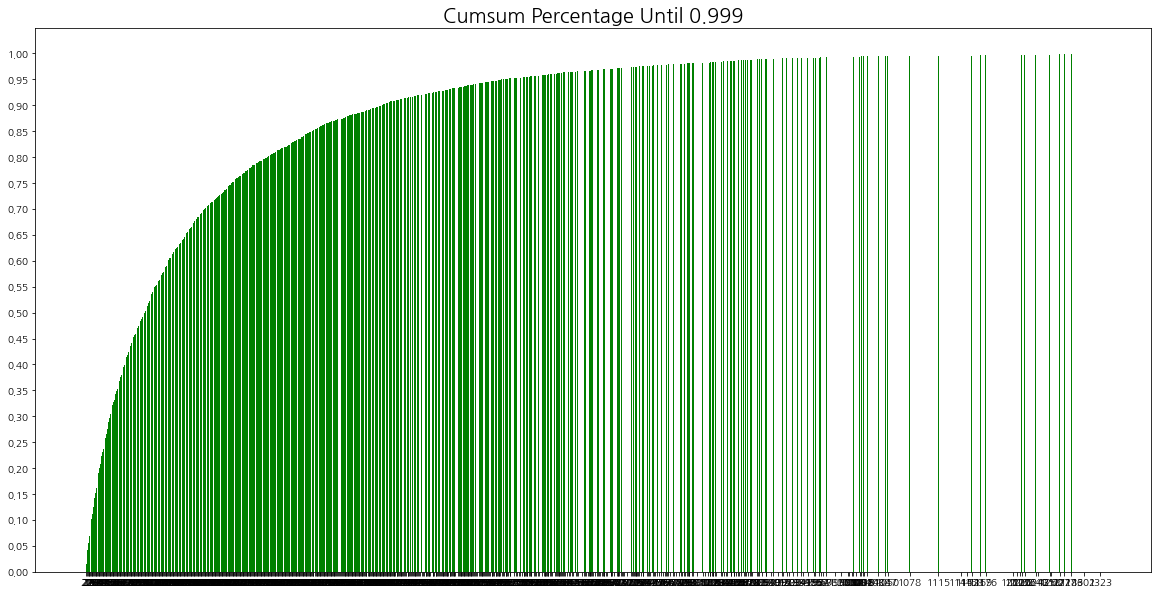

In [12]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='g')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

**✓ Session Time : 최근 소비 트렌드를 학습하는 것이 중요**

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()

print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


대략 3년치의 자료네요!

In [14]:
type(oldest)

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
month_ago = latest - dt.timedelta(30)  # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]  # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-03 06:08:38
27759,195,1254,4,2003-02-07 02:23:42
27921,195,1456,2,2003-02-08 09:07:32
28443,195,468,3,2003-02-12 02:42:36
28255,195,2748,1,2003-02-12 03:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-28 03:13:57
984682,5950,3578,4,2003-02-28 03:14:30
984475,5950,3793,3,2003-02-28 03:15:10
984660,5950,3555,2,2003-02-28 03:15:37


**✓ Data Cleansing : 주요 통계치들을 살펴봅시다.**

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
58836,398,2028,4,2003-02-07 06:03:45
58784,398,2762,5,2003-02-07 06:09:13
58730,398,2628,3,2003-02-07 06:18:16
58837,398,3697,2,2003-02-07 06:21:04
58645,398,1196,4,2003-02-07 06:39:01
62105,419,2424,4,2003-02-11 03:10:24
62170,419,2028,5,2003-02-11 03:13:21
62078,419,1196,5,2003-02-11 03:15:20
62145,419,2762,5,2003-02-11 03:22:08
62071,419,3793,4,2003-02-11 03:22:34


**✓ Train/ Valid/ Test split : 주요 통계치들을 살펴봅시다.**

추천 시스템은 지금 잘 예측하는 게 중요

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [20]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 28
	 Sessions: 6
	 Items: 7
	 First Time : 2003-02-01 11:39:15
	 Last Time : 2003-02-22 06:22:26

* valid Set Stats Info
	 Events: 5
	 Sessions: 2
	 Items: 4
	 First Time : 2003-02-25 02:02:07
	 Last Time : 2003-02-26 04:06:15

* test Set Stats Info
	 Events: 2
	 Sessions: 1
	 Items: 2
	 First Time : 2003-02-28 02:53:37
	 Last Time : 2003-02-28 03:15:10



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step2. 미니 배치의 구성
---
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

**✓ SessionDataset**

In [25]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [26]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
58836,398,2028,4,2003-02-07 06:03:45,0
58784,398,2762,5,2003-02-07 06:09:13,1
58730,398,2628,3,2003-02-07 06:18:16,2
58837,398,3697,2,2003-02-07 06:21:04,3
58645,398,1196,4,2003-02-07 06:39:01,4
62105,419,2424,4,2003-02-11 03:10:24,5
62170,419,2028,5,2003-02-11 03:13:21,0
62078,419,1196,5,2003-02-11 03:15:20,4
62145,419,2762,5,2003-02-11 03:22:08,1
62071,419,3793,4,2003-02-11 03:22:34,6


In [27]:
tr_dataset.click_offsets

array([ 0,  5, 10, 15, 21, 24, 28], dtype=int32)

In [28]:
tr_dataset.session_idx

array([0, 1, 2, 3, 4, 5])

**✓ SessionDataLoader**

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
58836,398,2028,4,2003-02-07 06:03:45,0
58784,398,2762,5,2003-02-07 06:09:13,1
58730,398,2628,3,2003-02-07 06:18:16,2
58837,398,3697,2,2003-02-07 06:21:04,3
58645,398,1196,4,2003-02-07 06:39:01,4
62105,419,2424,4,2003-02-11 03:10:24,5
62170,419,2028,5,2003-02-11 03:13:21,0
62078,419,1196,5,2003-02-11 03:15:20,4
62145,419,2762,5,2003-02-11 03:22:08,1
62071,419,3793,4,2003-02-11 03:22:34,6


In [31]:
iter_ex = iter(tr_data_loader)

In [32]:
inputs, labels, mask =  next(iter_ex)

print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 5 1 3]
Label Item Idx are :       [1 0 2 0]
Previous Masked Input Idx are []


### Step3. 모델 구성
---
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

def create_model_2(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True,return_sequences=True, name='GRU1')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU2')(dropout)
    dropout = Dropout(args.drop_rate)(gru)
    
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
# 하이퍼 파라미터
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=30, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args1 = Args(tr, val, test, batch_size=64, hsz=60, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args2 = Args(tr, val, test, batch_size=64, hsz=30, drop_rate=0.2, lr=0.001, epochs=5, k=20)
args3 = Args(tr, val, test, batch_size=64, hsz=15, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [36]:
# 모델 만들기
model = create_model(args)
model1 = create_model(args1)
model2 = create_model(args2)
model3 = create_model(args3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 7)]              0         
_________________________________________________________________
GRU (GRU)                    [(64, 30), (64, 30)]      3510      
_________________________________________________________________
dropout (Dropout)            (64, 30)                  0         
_________________________________________________________________
dense (Dense)                (64, 7)                   217       
Total params: 3,727
Trainable params: 3,727
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 7)]              0         
__________________________________________

### Step4. 모델 학습
---
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.
            #reset_hidden_states_2(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            
            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def reset_hidden_states_2(model, mask):
    gru_layer = model.get_layer(name='GRU1')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    gru_layer = model.get_layer(name='GRU2')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)
    
    

def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []
    total_step = len(data) - data['UserId'].nunique()
    
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        #reset_hidden_states_2(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
train_model(model, args)

Train: 0it [00:00, ?it/s]


IndexError: index 6 is out of bounds for axis 0 with size 6

In [ ]:
train_model(model1, args1)

In [ ]:
train_model(model2, args2)

In [ ]:
train_model(model3, args3)

### Step5. 모델 테스트
---
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

In [ ]:
test_model(model1, args1, test)

In [ ]:
test_model(model2, args2, test)

In [ ]:
test_model(model3, args3, test)

# 루브릭 평가 기준
---
번호|평가문항|상세기준
---|---|---
1 |Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2 |RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3 |세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

# 회고
---